# Training the Model on the euroSat dasaset. 


This dataset was quite similar to the our usecase  with 10 classes and would act as a fact check. The data needs to be downloaded. The final model accuracy is 92% on  which quite good. This dataset is supposed to act as a benchmark for our main kenya dataset.


## Brief about SCAN algorithm: Its divided into 3 parts. 
  1. pretext model : Trained by running the simclr.py 
  2. scan model : Trained by running the scan.py 
  3. Selflabel model : This is the same model used in the stage 2. We only fine tune the scan output here. This stage is optional. `To learn more abt the algorithm read the getting started notebook in the SCAN folder.` 


## Different Sections

1. **Creating dataset.**  
   we need 2 folders one containing jpeg images and the other containing tiff images.  The model is trained on the jpeg images and the tiff images are used to obtain the x,y cordinates. 

2. Calculating the mean and std for the kenya dataset. 
    
    (**step 1 and 2 need to run only once**)


3. Training the pretext part 

4. Plot the clusters using pretext model + Kmeans : (this part is optional)

5. Train the scan model 

6. Train the selflabel model: (optional)  The output of scan and self-label is the same hence the code in step 7 stays same.



## Outputs to trained models: 
  1. pretext model : output dim (256) user defined. 
  2. scan and self-label : Vector of dim C (where C = no. clusters)



## Important Tips:

  At the end of training the pretext model produces topK-train_neighbours and topk-val_neighbours this are used as inputs to the scan along with the weigths of the pretext model. 







In [ ]:
!nvidia-smi

Thu Dec  3 11:45:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## download the original eurosat dataset.

In [ ]:
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip

In [ ]:
!ls -lh

total 199M
drwx------ 2 root root 4.0K Nov 15 03:54 cifar-10
drwx------ 2 root root 4.0K Nov 11 10:51 configs
drwx------ 2 root root 4.0K Nov 11 10:51 data
drwx------ 2 root root 4.0K Nov 18 07:19 euroSAT
drwx------ 2 root root 4.0K Nov 22 10:02 euroSAT2
drwx------ 2 root root 4.0K Nov 22 10:18 euroSAT3
drwx------ 2 root root 4.0K Dec  1 15:21 euroSAT7
-rw------- 1 root root 5.9K Nov 18 08:27 eval.py
drwx------ 2 root root 4.0K Nov 11 10:51 images
-rw------- 1 root root 199M Dec  3 07:23 images.npz
-rw------- 1 root root 6.3K Nov 18 08:32 img.jpg
drwx------ 2 root root 4.0K Nov 11 10:51 logs
drwx------ 2 root root 4.0K Nov 11 10:51 losses
-rw------- 1 root root 4.5K Nov 11 10:51 moco.py
drwx------ 2 root root 4.0K Nov 11 10:51 models
-rw------- 1 root root 537K Dec  3 07:16 pred.csv
-rw------- 1 root root 3.3K Nov 11 10:51 requirements.txt
drwx------ 2 root root 4.0K Nov 29 15:56 SCAN
-rw------- 1 root root 5.7K Nov 21 10:07 scan.py
-rw------- 1 root root 4.6K Nov 25 09:31 selflabel.py

In [ ]:
!pip install faiss-gpu                       # For efficient nearest neighbors search 
!pip install pyyaml easydict                 # For using config files
!pip install termcolor                       # For colored print statements
# !pip install --ignore-installed PyYAML

     |████████████████████████████████| 67.7MB 46kB/s 


DataSet link

To train on custom dataset 
1. we need to create the data loader 
2. we need to create config files for each stage seperately.

In [1]:
#getting class info.
 
import os 
import pandas as pd
import numpy as np

## Run this below cell to generate the euroSAT_df.csv file 

In [3]:
def get_data_dict(data_dir):

    data_dict = {'path': [], 'label': []}

    for  label in os.listdir(data_dir):

            label_dir = data_dir + label + '/'
            for files in os.listdir(label_dir):

                    data_dict['path'].append(label_dir + files)
                    data_dict['label'].append(label)

    df =  pd.DataFrame(data_dict)

    return df

data_path = 'path_to_dataset'
df = get_data_dict(data_path)
df.to_csv('data/euroSAT_df.csv',index = False)

## Demo Dataset for Calculating Custom Mean and Std. 

The original dataset returns a dict which takes a lot of time to loop throught the samples. So for calculating the mean and std 


In [ ]:
#creating a custom dataloader 
"""
This code is based on the Torchvision repository, which was licensed under the BSD 3-Clause.
"""
import os
import pickle
import sys
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision.datasets.utils import check_integrity, download_and_extract_archive
from torchvision.transforms import Compose,ToTensor,Normalize
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import cv2
from tqdm import tqdm
 
class EuroSat(Dataset):
 
    def __init__(self, df, transform=None):
 
        super(EuroSat, self).__init__()
        
        self.transform = transform
         
        
        self.classes = ['Forest','SeaLake','PermanentCrop','Industrial','River','AnnualCrop','HerbaceousVegetation','Residential','Highway','Pasture']
 
        
        self.df = df
 
        #keep 75 for training and 
 
        
 
 
  
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            dict: 
        """
 
        img = self.get_image(index)
        img_size = img.size
        
        class_name = self.df['label'][index]
        target = self.classes.index(class_name)
 
 
        if self.transform is not None:
            img = self.transform(img)
        
        return img
 
    def get_image(self, index):
        img_path = self.df['path'][index]   
        img = Image.open(img_path)
        img = img.convert('RGB')
        return img
 
    #functions used for plotting images     
    def show_img(self,index,aug = False):
        img =  self.get_image(index)
 
        if aug:
          img = self.transform(img).permute(1,2,0)
        
        plt.imshow(img)
    
    # will create a batch x batch images 
    def plot_batch(self,batch = 8,aug = False,indices = None,size = (20,20)):
 
        
        n_images = len(self.df)
 
        if indices == None:
           indices = np.random.choice(range(n_images) , size= batch **2) 
 
        #creating an image array 
        labels = self.df['label'][indices].reset_index(drop = True)
    
        images = [self.get_image(i) for i in indices]
        
        fig,axis = plt.subplots(batch,batch,figsize = size)
 
 
        for i,ax in enumerate(axis.flatten()):
 
            if aug:
                ax.imshow(self.transform(images[i]).permute(1,2,0))
            else: 
                ax.imshow(images[i])
 
            ax.set_title(labels[i])
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
             
    
    def __len__(self):
        return len(self.df)

27000


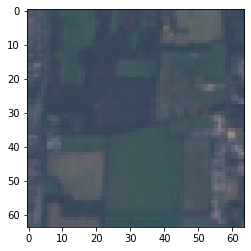

In [ ]:
'''
 mean: [0.3444, 0.3803, 0.4078]
  std: [0.2509, 0.1718, 0.1458]
'''
 
transform= Compose([ToTensor(),
                    Normalize(mean = [0.3444,0.3803,0.4078],
                              std = [0.2509,0.1718,0.1458])
                    ])
 
df = pd.read_csv("./data/euroSAT_df.csv")
 

eurodataset = EuroSat(df,transform=transform)
  
print(len(eurodataset))  
eurodataset.show_img(10)

# Calculaing Mean and Std

In [ ]:
# num = len(eurodataset) 
# print(num)

27000


In [ ]:
# loader = torch.utils.data.DataLoader(eurodataset, batch_size=100, num_workers=4,shuffle = False)

# total_pix = num * 64 * 64


# mean = {'red':0,'green':0,'blue':0}
# std = {'red':0,'green':0,'blue':0}

# print('calculating mean')

# for data in tqdm(loader):

#     mean['red'] += data[:,0,:,:].sum() / total_pix
#     mean['green'] += data[:,1,:,:].sum() / total_pix
#     mean['blue'] += data[:,2,:,:].sum() / total_pix
    

In [ ]:
mean

{'blue': tensor(0.4078), 'green': tensor(0.3803), 'red': tensor(0.3444)}

In [ ]:
# print('calculating std')
# sum_of_squared_error = 0

# for data in tqdm(loader): 
#     std['red'] += ((data[:,0,:,:] - mean['red']).pow(2)).sum()
#     std['green'] += ((data[:,1,:,:] - mean['blue']).pow(2)).sum()
#     std['blue'] += ((data[:,2,:,:] - mean['green']).pow(2)).sum()



# std['red'] = torch.sqrt(std['red'] / total_pix)
# std['green'] = torch.sqrt(std['green'] / total_pix)
# std['blue'] = torch.sqrt(std['blue'] / total_pix)

In [ ]:
mean,std

({'blue': tensor(0.4078), 'green': tensor(0.3803), 'red': tensor(0.3444)},
 {'blue': tensor(0.1458), 'green': tensor(0.1718), 'red': tensor(0.2509)})

## Training the Pretext Model

The  output of Pretext model is  a  128 dim  vec this is user defined and can be configured in the pretext.config file.


In [1]:
!python simclr.py --config_env configs/env.yml --config_exp configs/pretext/simclr_euroSAT7.yml

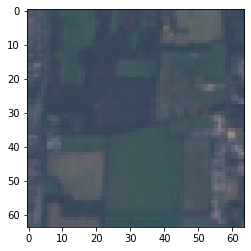

In [ ]:
from data.euroSAT import EuroSat
 
transform= Compose([ToTensor(),
                    Normalize(mean = [0.3444,0.3803,0.4078],
                              std = [0.2509,0.1718,0.1458])
                    ])
 
df = pd.read_csv("./data/euroSAT_df.csv")
 


eurodataset = EuroSat(df)

eurodataset.show_img(10)

## Checking the neighbours

One of the most important output of the pretext stage is the neighbors files produced. The first index of this file denotes the index of a image in the dataset and the rest indices are supposed to be its nearest neighbors determined by the pretext model. This will be used to train the SCAN model in the next step. Hence then need to be as accurate as possiable. 


Since this dataset was originally intented to be used for supervised task we the labels and can cross check if the pretext model is doing a good job or not. In a ideal situation we would like to see all the rows having the same class. Will have 21 columns as we have mined for 20 neighbours and 1 for the image.



In [ ]:
arr = np.load('euroSAT7/pretext/topk-train-neighbors.npy')
 

for i in range(100):
  for j in range(21):
    print(eurodataset[arr[4500+i][j]]['target'],end = " ")
  print()

4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 
5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 
5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 8 5 3 
4 4 4 4 4 5 4 4 4 4 4 5 4 4 4 4 4 5 4 4 5 
8 8 8 8 8 8 8 8 8 8 8 8 8 4 8 8 8 8 8 8 8 
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 
3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 
3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 
6 6 6 6 6 6 6 6 6 2 6 6 6 6 6 6 6 6 6 6 6 
8 8 8 8 8 8 4 8 6 8 8 8 8 8 4 8 8 8 8 8 8 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
4 4 4 4 4 6 4 4 4 4 4 4 4 4 4 4 4 4 5 4 4 
6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 
6 6 

KeyboardInterrupt: ignored

# Stage 2. Scan Algorithem.

Use the the 

In [ ]:
!python scan.py --config_env configs/env.yml --config_exp configs/scan/scan_euroSAT.yml

{'setup': 'scan', 'train_dir': 'euroSAT7', 'criterion': 'scan', 'criterion_kwargs': {'entropy_weight': 5.0}, 'update_cluster_head_only': False, 'num_heads': 1, 'backbone': 'resnet18', 'train_db_name': 'euroSAT', 'val_db_name': 'euroSAT', 'num_classes': 10, 'num_neighbors': 20, 'augmentation_strategy': 'ours', 'augmentation_kwargs': {'crop_size': 64, 'normalize': {'mean': [0.3444, 0.3803, 0.4078], 'std': [0.2509, 0.1718, 0.1458]}, 'num_strong_augs': 4, 'cutout_kwargs': {'n_holes': 1, 'length': 16, 'random': True}}, 'transformation_kwargs': {'crop_size': 64, 'normalize': {'mean': [0.3444, 0.3803, 0.4078], 'std': [0.2509, 0.1718, 0.1458]}}, 'optimizer': 'adam', 'optimizer_kwargs': {'lr': 0.0001, 'weight_decay': 0.0001}, 'epochs': 150, 'batch_size': 128, 'num_workers': 8, 'scheduler': 'constant', 'pretext_dir': './euroSAT7/pretext', 'pretext_checkpoint': './euroSAT7/pretext/checkpoint.pth.tar', 'pretext_model': './euroSAT7/pretext/model.pth.tar', 'topk_neighbors_train_path': './euroSAT7/pr

# Evaluating the SCAN Model 
1. make sure the dataset has been downloaded 
2. The model is present in Weights/euroSAT/scan/model.path.tar

In [1]:
from models.models import ClusteringModel
from models.resnet_cifar import resnet18
import torch

state_dict = torch.load('Weights/euroSAT/scan/model.pth.tar',map_location=torch.device('cpu'))

# print(state_dict['model'].keys())

backbone = resnet18()
model = ClusteringModel(backbone, 10, 1)
model.load_state_dict(state_dict['model'])
# model = model.cuda()
model.eval()


ClusteringModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [3]:

#getting the config
from utils.common_config import get_train_dataset,get_train_dataloader,get_val_transformations
from utils.config import create_config
from torchvision.transforms import Compose,ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm


p = create_config('configs/env.yml','configs/scan/scan_euroSAT.yml')

#for evaluating will be only using the get_val_transforms
transforms = get_val_transformations(p)

print(transforms)

train_dataset = get_train_dataset(p, transforms)


print(len(train_dataset))

loader = torch.utils.data.DataLoader(train_dataset, num_workers=4,batch_size=128)


data_file = {'gt':[],'pred':[],'className':[]}

for data in tqdm(loader):
    data_file['gt'].extend(data['target'].numpy())
    data_file['className'].extend(data['meta']['class_name'])
    data_file['pred'].extend(torch.argmax(model(data['image'].cuda())[0],dim = 1).cpu().detach().numpy())
    

In [ ]:
data_file.keys()

dict_keys(['gt', 'pred', 'className'])

# Producing the Cluster - to - Class Map. 

Since the scan model is randomly going to assign each cluster during training as there is nothing supervising it (labels).If we cant to compare the labels to the predictions we need to create this mapping. 

To label a cluster we assign it the most common class appearing in that cluster to do this the mode() function is used.



In [ ]:
import pandas as pd 
import statistics
'''
keys are the  preds and values are the gt. 

we will be mapping the preds to gt targets.

'''

labels_df = pd.DataFrame(data_file)
gp = labels_df.groupby('gt')


vals = gp.aggregate(statistics.mode).iloc[:,0:-1]


mapping = { j[0]:i  for i,j in zip(list(vals.index),vals.values)}

# for i,j in zip(list(vals.index),vals.values):

#   print(i,j)
mapping





{0: 2, 1: 7, 2: 3, 3: 6, 4: 9, 5: 5, 6: 0, 7: 8, 8: 4, 9: 1}

In [ ]:
from sklearn.metrics import accuracy_score

labels_df['mapped_preds'] = labels_df['pred'].map(lambda x : mapping[x])

# df[['gt','mapped_preds']]    

accuracy_score(labels_df['gt'].values,labels_df['mapped_preds'].values)


0.9241481481481482

## Final accuracy was 92%

In [ ]:
labels_df

,Unnamed: 0,gt,pred,className,mapped_preds
0,0,5,5,AnnualCrop,5
1,1,9,4,Pasture,9
2,2,0,6,Forest,0
3,3,7,1,Residential,7
4,4,9,4,Pasture,9
...,...,...,...,...,...
26995,26995,1,9,SeaLake,1
26996,26996,3,2,Industrial,3
26997,26997,2,0,PermanentCrop,2
26998,26998,3,2,Industrial,3


In [ ]:
labels_df.to_csv("data/pred.csv",index = False)

In [ ]:
train_dataset[1]['target']

9

# Labeling the dataset 


Now that we have the clustre mapping we can label our dataset. Lets plot our dataset on a 2-d scatter plot. To do this we need to perform two steps.

1. Use Pca or Tsne to create a 2-d scatter plot. 
2. Then use labels to color the clusters.  



In [ ]:
%matplotlib inline 
import matplotlib.pyplot as plt
import plotly.offline as py 
import plotly.graph_objs as go 
import plotly.tools as tls 
from tqdm import tqdm

In [ ]:
df = pd.read_csv("./data/euroSAT_df.csv")
df.head()

,path,label,train
0,../../EuroSAT/2750/AnnualCrop/AnnualCrop_1985.jpg,AnnualCrop,1
1,../../EuroSAT/2750/Pasture/Pasture_1641.jpg,Pasture,1
2,../../EuroSAT/2750/Forest/Forest_2021.jpg,Forest,1
3,../../EuroSAT/2750/Residential/Residential_375...,Residential,1
4,../../EuroSAT/2750/Pasture/Pasture_375.jpg,Pasture,1


In [ ]:
labels_df = pd.read_csv('data/pred.csv')
labels_df.head()

,Unnamed: 0,gt,pred,className,mapped_preds
0,0,5,5,AnnualCrop,5
1,1,9,4,Pasture,9
2,2,0,6,Forest,0
3,3,7,1,Residential,7
4,4,9,4,Pasture,9


Reading In all images

In [ ]:
import cv2
all_img = []
for path in tqdm(df['path']):
    img = cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)
    # img = cv2.normalize(img,0.0,1.0,cv2.NORM_MINMAX)
    all_img.append(img.reshape(1,-1))

100%|██████████| 27000/27000 [00:54<00:00, 491.72it/s]


### Will need to reshape the images to a 1-d vector as required by PCA and TSNE

In [ ]:
img_mat = np.vstack(all_img)
img_mat.shape

(27000, 12288)

In [ ]:
np.savez_compressed('images',img_mat)

### Using tsne

In [ ]:
from sklearn.manifold import TSNE 

tsne = TSNE(n_components = 2,init = 'random',method = 'barnes_hut',n_iter = 500,verbose = 2)
dims = tsne.fit_transform(img_mat[0:1000])



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 1.184s...
[t-SNE] Computed neighbors for 1000 samples in 24.960s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 500.722743
[t-SNE] Computed conditional probabilities in 0.086s
[t-SNE] Iteration 50: error = 80.1347961, gradient norm = 0.3569784 (50 iterations in 0.430s)
[t-SNE] Iteration 100: error = 85.3623199, gradient norm = 0.2872957 (50 iterations in 0.404s)
[t-SNE] Iteration 150: error = 85.2641449, gradient norm = 0.3168495 (50 iterations in 0.401s)
[t-SNE] Iteration 200: error = 86.0971680, gradient norm = 0.2663630 (50 iterations in 0.393s)
[t-SNE] Iteration 250: error = 84.6514664, gradient norm = 0.3031021 (50 iterations in 0.436s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.651466
[t-SNE] Iteration 300: error = 1.5473869, gradient norm = 0.0072455 (50 iterations in 0.442s)
[t-SNE] Iteration 350: error = 1.2735362, gradient norm = 0.00

# Scatter plot With Ground Truth Labels 





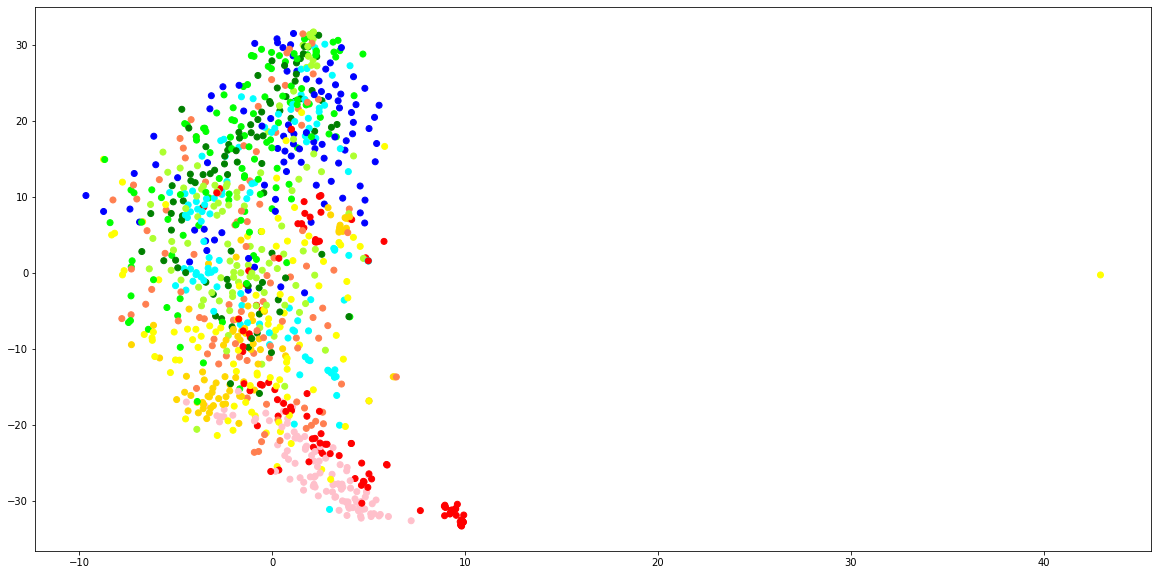

In [ ]:
colors = {0:'pink',1:'red', 2:'green', 3:'blue', 4:'yellow',5:'lime',6:'cyan',7:'greenyellow',8:'coral',9:'gold'}


plt.figure(figsize=(20,10))
plt.scatter(dims[0:1000,0],dims[0:1000,1],c = labels_df['gt'].map(colors)[0:1000])
# labels_df['gt'].map(colors)[0:1000]

# Plot with Scan (pred) Labels 

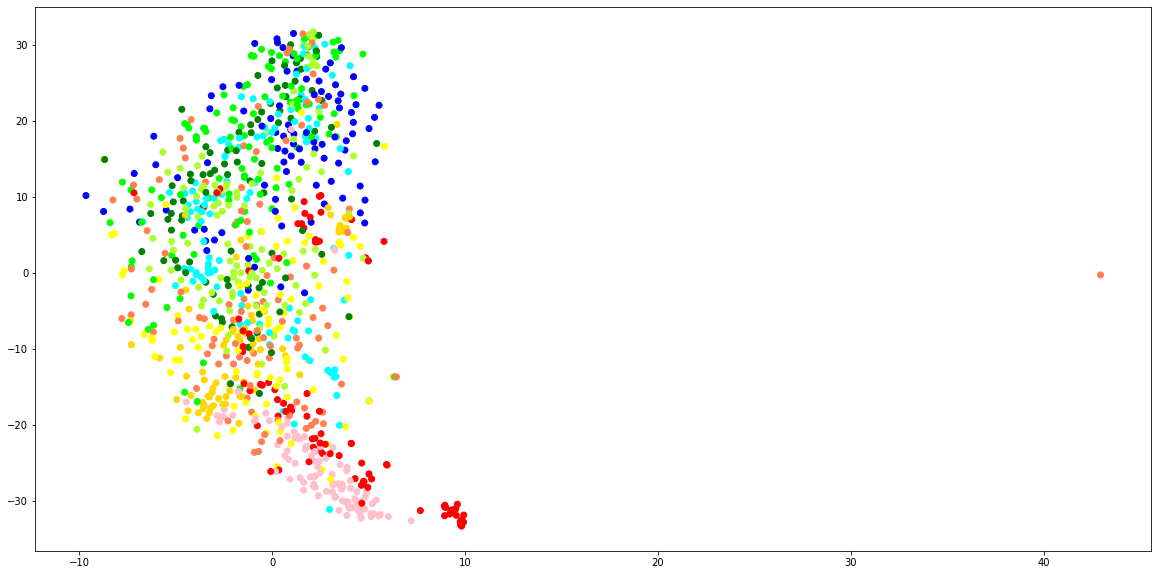

In [ ]:

colors = {0:'pink',1:'red', 2:'green', 3:'blue', 4:'yellow',5:'lime',6:'cyan',7:'greenyellow',8:'coral',9:'gold'}


plt.figure(figsize=(20,10))
plt.scatter(dims[:,0],dims[:,1],c = labels_df['mapped_preds'].map(colors)[0:1000])
# labels_df['gt'].map(colors)[0:1000]

As one can see SCAN has done a great job at predicting the labels

## Now using PCA 

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
dims = pca.fit_transform(img_mat)


# Comparing the ground truth with  predictions


In [ ]:
from matplotlib.colors import ListedColormap
def get_scatterplot(dims,df,title,ax,col,rows):

  classes = ['Forest','SeaLake','PermanentCrop','Industrial','River','AnnualCrop','HerbaceousVegetation','Residential','Highway','Pasture']
  # colors = {0:'pink',1:'red', 2:'green', 3:'blue', 4:'yellow',5:'lime',6:'cyan',7:'greenyellow',8:'coral',9:'gold'}
  values =  df[col].values
  colors = ListedColormap(['pink','red','green','blue','yellow','lime','cyan','greenyellow','coral','gold'])

  scatter = ax.scatter(dims[:,0],dims[:,1],c = values[0:rows],cmap = colors)
  plt.legend(handles=scatter.legend_elements()[0], labels=classes)
  ax.set_title(title)


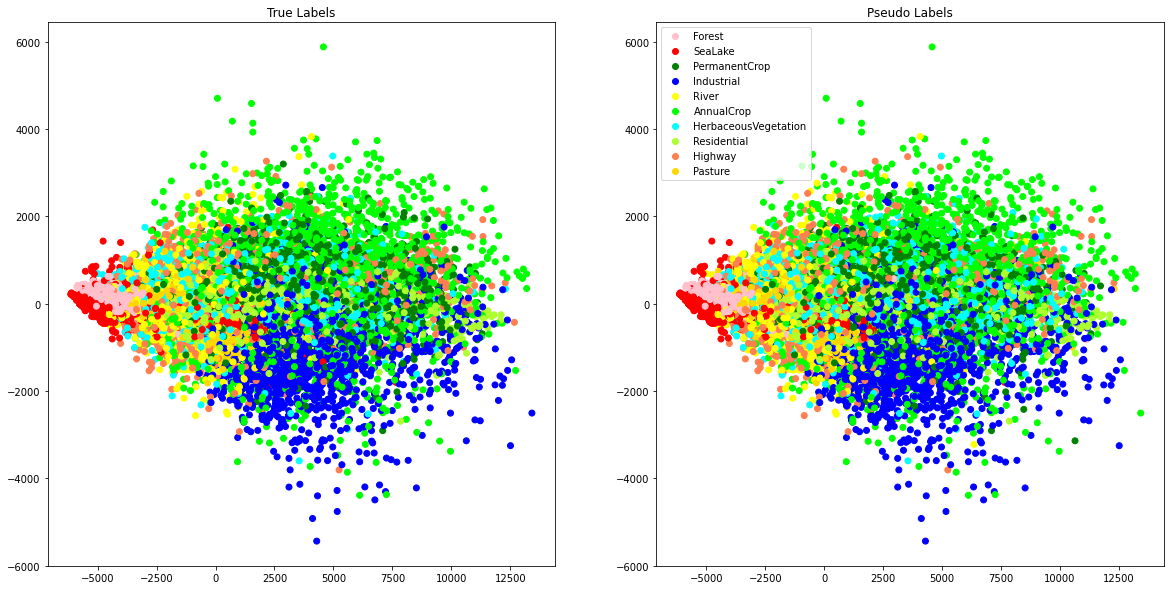

In [ ]:
fig,axis = plt.subplots(1,2,figsize = (20,10))

get_scatterplot(dims,labels_df,title = "True Labels",ax = axis[0] ,col = 'gt',rows = 27000)
get_scatterplot(dims,labels_df,title = "Pseudo Labels",ax = axis[1] ,col = 'mapped_preds',rows = 27000)



### We got 92 % accuracy using a Unsupervised Approach Now lets look our errors

# Plot incorrect Labels  (%8)

In [ ]:
error_df = labels_df[labels_df['gt'] != labels_df['mapped_preds']]

error_index = error_df.index

error_images = img_mat[error_index]

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
error_dims = pca.fit_transform(error_images)


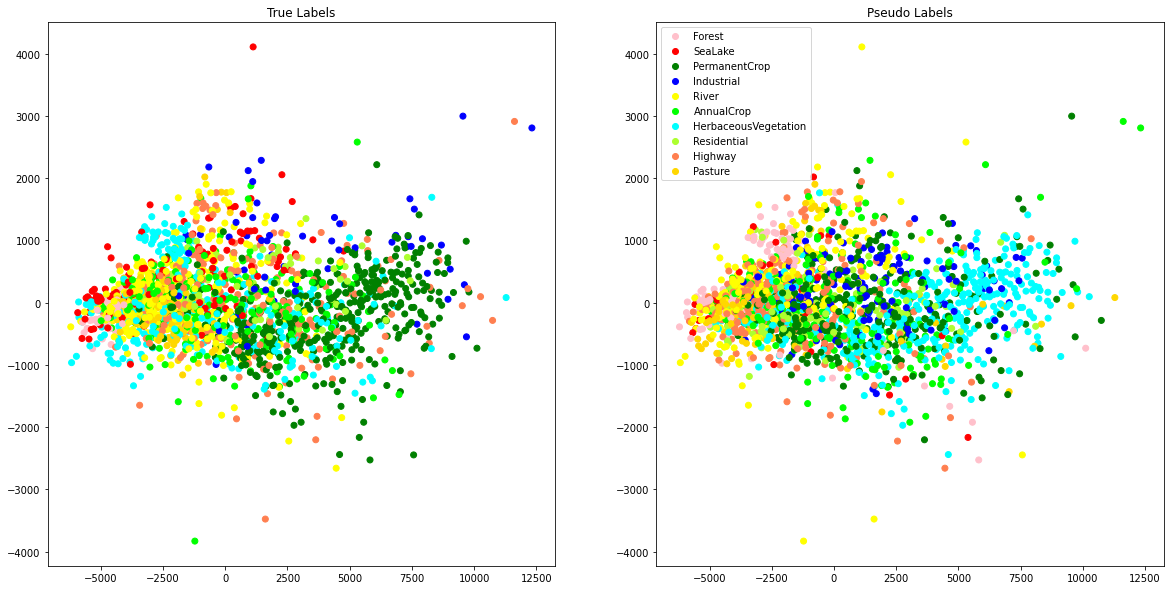

In [ ]:
fig,axis = plt.subplots(1,2,figsize = (20,10))

get_scatterplot(dims = error_dims,df = error_df,title = "True Labels",ax = axis[0] ,col = 'gt',rows = len(error_dims))
get_scatterplot(dims = error_dims,df = error_df,title = "Pseudo Labels",ax = axis[1] ,col = 'mapped_preds',rows = len(error_dims))



# 3D Plots

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
dims = pca.fit_transform(img_mat)


In [ ]:

import plotly.express as px 
  

fig = px.scatter_3d(x = dims[:,0],  
                    y = dims[:,1],    
                    z = dims[:,2],  
                    color = labels_df['className']
                    ) 
  
fig.show()




## Self - Label

One observation made her is the self-label models performace depends on the batch_size. For cifar-10 the batch_size was set to 1000. But for eurosat the highest I could set was 300


In [ ]:
!python selflabel.py --config_env configs/env.yml --config_exp configs/selflabel/selflabel_euroSAT.yml

{'setup': 'selflabel', 'train_dir': 'euroSAT7', 'use_ema': False, 'confidence_threshold': 0.99, 'criterion': 'confidence-cross-entropy', 'criterion_kwargs': {'apply_class_balancing': True}, 'backbone': 'resnet18', 'num_heads': 1, 'train_db_name': 'euroSAT', 'val_db_name': 'euroSAT', 'num_classes': 10, 'augmentation_strategy': 'ours', 'augmentation_kwargs': {'crop_size': 64, 'normalize': {'mean': [0.3444, 0.3803, 0.4078], 'std': [0.2509, 0.1718, 0.1458]}, 'num_strong_augs': 4, 'cutout_kwargs': {'n_holes': 1, 'length': 16, 'random': True}}, 'transformation_kwargs': {'crop_size': 64, 'normalize': {'mean': [0.3444, 0.3803, 0.4078], 'std': [0.2509, 0.1718, 0.1458]}}, 'optimizer': 'sgd', 'optimizer_kwargs': {'lr': 0.0001, 'weight_decay': 0.0, 'nesterov': False, 'momentum': 0.9}, 'epochs': 25, 'batch_size': 512, 'num_workers': 8, 'scheduler': 'constant', 'pretext_dir': './euroSAT7/pretext', 'pretext_checkpoint': './euroSAT7/pretext/checkpoint.pth.tar', 'pretext_model': './euroSAT7/pretext/mod

## The final model accuracy is 92%

**Conclusion** : Using SCAN we can produce get results with no supervision (labels) but the training time required to train the algorithm is quite high compared to a supervised model. A resNet can get higher accuracy than 92% is less than 30 min where as SCAN takes abt. 5 hrs to train. But when labels are not present this technique is quite reliable.